In [0]:
import h5py
import numpy as np
import dis 
import os
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from keras.datasets import mnist
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.engine.topology import Layer, InputSpec
from keras.optimizers import SGD, Adam, RMSprop
from keras import callbacks
from keras.initializers import VarianceScaling
from keras.regularizers import l2, l1
from keras.layers import Lambda



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Load data 

1.   USPS
2.   Mnist




In [0]:
def load_usps(usps_file: Path = './usps.h5') -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    with h5py.File(usps_file, 'r') as usps_open:
        train = usps_open.get('train')
        train_data = train.get('data')[:]
        train_labels = train.get('target')[:]
        test = usps_open.get('test')
        test_data = test.get('data')[:]
        test_labels = test.get('target')[:]
        
    return train_data, train_labels, test_data, test_labels

In [8]:
usps_train_data, usps_train_labels, usps_test_data, usps_test_labels = load_usps()
(mnist_train_data, mnist_train_labels), (mnist_test_data, mnist_test_labels) = mnist.load_data()
print(f'USPS training data shape: {usps_train_data.shape}')
print(f'USPS test data shape: {usps_test_data.shape}')
print(f'MNIST training data shape: {mnist_train_data.shape}')
print(f'MNIST test data shape: {mnist_test_data.shape}')

11493376/11490434 [==============================] - 0s 0us/step
USPS training data shape: (7291, 256)
USPS test data shape: (2007, 256)
MNIST training data shape: (60000, 28, 28)
MNIST test data shape: (10000, 28, 28)


# Visualize Data
Uses t-SNE plots

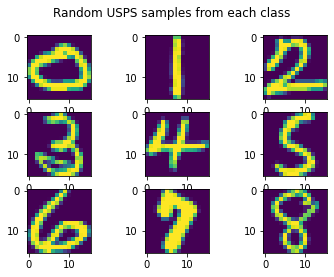

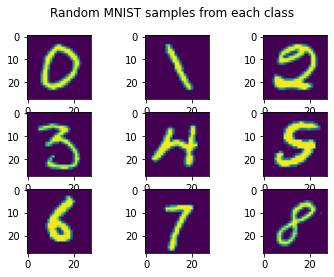

In [9]:
np.random.seed(42)
def plot_sample_grid(train_data: np.ndarray,
                     train_labels: np.ndarray,
                     img_width: int,
                     img_height: int,
                     dataset_name: str,
                     img_grid_width: int = 3,
                     img_grid_height: int = 3) -> None:
    unique_labels = np.unique(train_labels)
    grid_fig = plt.figure()
    for i in range(img_grid_width * img_grid_height):
        label_ix = np.argwhere(unique_labels[i] == train_labels).flatten()
        random_label_ix = np.random.choice(label_ix, 1)
        random_label_img = train_data[random_label_ix, :]
        random_label_img = np.reshape(random_label_img, (img_height, img_width))
        grid_fig.add_subplot(img_grid_height, img_grid_width, i+1)
        plt.imshow(random_label_img)
    grid_fig.suptitle(f'Random {dataset_name} samples from each class')
    plt.show()
    
    
plot_sample_grid(usps_train_data, 
                 usps_train_labels, 
                 img_width=16, 
                 img_height=16, 
                 dataset_name = 'USPS')
plot_sample_grid(mnist_train_data, 
                 mnist_train_labels, 
                 img_width=28, 
                 img_height=28, 
                 dataset_name = 'MNIST')

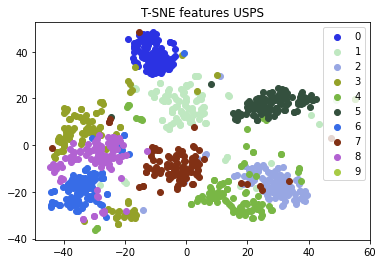

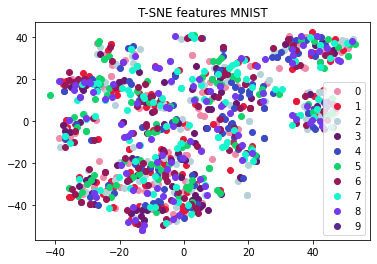

In [10]:
def plot_tsne(data: np.ndarray,
              labels: np.ndarray,
              dataset_name: np.ndarray,
              num_samples_per_class: int = 100) -> None:
    unique_labels = np.unique(labels)
    x_tsne = np.array([])
    for i in range(len(unique_labels)):
        label_ix = np.argwhere(unique_labels[i] == labels).flatten()
        random_labels_ix = np.random.choice(label_ix, num_samples_per_class)
        random_label_data = data[random_labels_ix, :]
        random_label_data = np.reshape(random_label_data, (num_samples_per_class, -1))
        if i == 0:
            x_tsne = random_label_data
        else:
            x_tsne = np.vstack((x_tsne, random_label_data))
    tsne_emb = TSNE(n_components=2).fit_transform(x_tsne)
    for i in range(len(unique_labels)):
        rgb = np.random.rand(3,)
        start_slice = (i+1)*num_samples_per_class
        stop_slice = (i+2)*num_samples_per_class
        x_plot = tsne_emb[()]
        plt.scatter(tsne_emb[start_slice:stop_slice, 0], tsne_emb[start_slice:stop_slice,1], c=[rgb])
    plt.title(f'T-SNE features {dataset_name}')
    plt.legend(unique_labels)
    plt.show()
    
plot_tsne(usps_train_data, 
          usps_train_labels, 
          dataset_name='USPS',
         num_samples_per_class=100)
plot_tsne(mnist_train_data, 
          usps_train_labels, 
          dataset_name='MNIST',
          num_samples_per_class=100)

# DEC Implementation with L2 Normalization : 
Makes use of base Dec implementation provided by https://github.com/XifengGuo/DEC-keras

In [0]:
def load_mnist_data():
    data = np.concatenate((mnist_train_data, mnist_test_data))
    labels =  np.concatenate((mnist_train_labels, mnist_test_labels))
    data = data.reshape((data.shape[0], -1))
    data = np.divide(data, 255.) 
    print('MNIST', data.shape)
    return data, labels

# build_dec() uses the base implementation from Dec.py by XifengGuo : https://github.com/XifengGuo/DEC-keras with l2 normalization/regularisation added
def build_dec(size_encoder, size_hidden, act, init, regularizer, normalizer):    
    # Encoder   
    x = Input(shape=(dims[0],), name='input')

    h = x
    
    for i in range(size_encoder-1):
        h = Dense(dims[i + 1], activation=act , kernel_initializer=init, name='encoder_%d' % i)(h)
     
    #Hidden Layer
    h =  Dense(dims[size_hidden], kernel_initializer=init, name='output_no_l2')(h) 

    #L2

    #if regularizer is None:
    h = Lambda(lambda x: normalizer(x,axis=1), name='output_l2')(h)
    #else :
    #    h =  Dense(dims[-1], kernel_initializer=init, activity_regularizer=regularizer , name='output_l2')(h)    
   
    y = h

    #Decoder 
    for i in range(size_encoder-1, 0, -1):
        y = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(y)

    #Output
    y = Dense(dims[0], kernel_initializer=init, name='decoder_0')(y)

    autoencoder = Model(inputs=x, outputs=y)
    encoder_l2 = Model(inputs=x,outputs=h)
    
    return autoencoder, encoder_l2

def build_encoder(autoencoder):
    encoder_no_l2 = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(name='output_no_l2').output)
    return encoder_no_l2

def build_l2_encoder(autoencoder):
    encoder_l2_2 = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(name='output_l2').output)
    return encoder_l2_2  


In [0]:
def plot_loss(history, optimizer):
    #Plot loss functions
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend([optimizer], loc='upper left')
    plt.show()

def load_weights(model, implementation, optimizer, epochs, batch_size):
    if os.path.exists('weights' + optimizer + implementation + '.h5'):
       autoencoder.load_weights('weights' + optimizer + implementation + '.h5')
       print('Loaded weights')
    else:       
       print('Couldnt find weights')
       autoencoder.compile(optimizer=optimizer, loss='mse')
        
       if optimizer == 'Adam':
          history_Adam = autoencoder.fit(data, data, batch_size=batch_size, epochs=epochs)
          autoencoder.save_weights('./weights_adam.h5')
          print("Saved model to disk")
          plot_loss(history, optimizer)

       if optimizer == 'RMSprop':
          history_RMSprop = autoencoder.fit(data, data, batch_size=batch_size, epochs=epochs)
          autoencoder.save_weights('./weights_rms.h5')
          print("Saved model to disk")
          plot_loss(history, optimizer)

def k_means(model):
      km = KMeans(n_clusters=len(np.unique(labels)))     
      label_pred = km.fit_predict(model.predict(data)) 
      return label_pred
    

MNIST samples (70000, 784)
Loaded weights
Encoder without L2 normalization


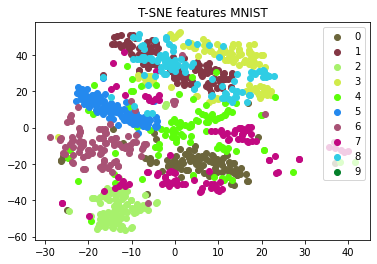

Encoder with L2 normalization


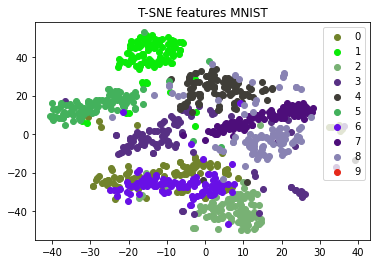

Encoder with L2 normalization (unsure about whether this L2 encoder parses correctly)


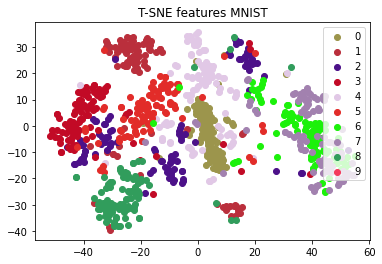

In [156]:
  #For building the autoencoder
  data, labels = load_mnist_data()
  dims = [data.shape[-1], 500, 500, 2000, 10]
  act='relu'
  init='glorot_uniform'
  size_encoder = len(dims) - 1
  size_hidden = -1 
  
  autoencoder, encoder = build_dec(size_encoder, size_hidden, act, init, regularizer=None, normalizer=K.l2_normalize)
  
  #For training the model
  batch_size = 256
  epochs = 200
  optimizer = 'Adam'
   
  load_weights(model=autoencoder, implementation='DEC', optimizer=optimizer, epochs=epochs, batch_size=batch_size)

  #For K-means clustering
  encoder_no_l2 = build_encoder(autoencoder)
  encoder_l2_2 = build_l2_encoder(autoencoder)
  encoder_l2 = encoder

  label_pred_no_l2 = k_means(encoder_no_l2)
  label_pred_l2_2 = k_means(encoder_l2)
  label_pred_l2 = k_means(encoder)
  
  #Plot t-SNE 
  print('Encoder without L2 normalization')
  plot_tsne(data, label_pred_no_l2, dataset_name='MNIST', num_samples_per_class=100)
  print('Encoder with L2 normalization')
  plot_tsne(data, label_pred_l2, dataset_name='MNIST', num_samples_per_class=100)
  print('Encoder with L2 normalization (unsure about whether this L2 encoder parses correctly)')
  plot_tsne(data, label_pred_l2_2, dataset_name='MNIST', num_samples_per_class=100)
  



#DCEC Implementation with L2 Normalization